# Model Performance: ALPR System

This notebook will walk through the ETL pipeline for this project, as well as display examples of raw images, object detection results, preprocessed images, and OCR text prediction results. 

### Import necessary modules 

In [1]:
from etl_pipeline import DataPipeline
import cv2
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

## Extract video frames <a class="anchor" name="check-inputs"></a>

In [2]:
dp = DataPipeline()

In [3]:
dp.extract("cars.mov")

Directory 'frames' already exists and is not empty.


In [4]:
len(dp.data)

60

The sample video is one minute long, at 60fps. I extracted every 60th frame from the full 3600-frame video, so my starting dataset is 60 images in total.

## Transform the extracted images<a class="anchor" id="transform"></a>

In [5]:
dp.transform()

Object detection model loaded successfully.
Images cropped successfully.
Image preprocessing steps completed successfully.


### Object Detection Results (YOLOv3 vs YOLOv3-tiny)<a class="anchor" id="object-det"></a>

In [6]:
len(dp.cropped_images)

35

There were 35 license plates detected by the YOLOv3 (full) object detection model. Here are some examples of those license plate images, before any additional processing steps.

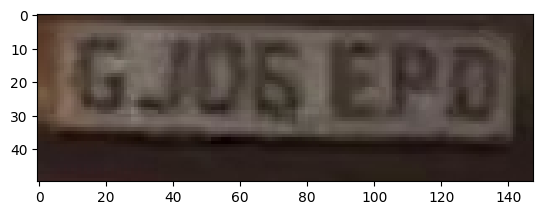

In [7]:
plt.imshow(dp.cropped_images[5])

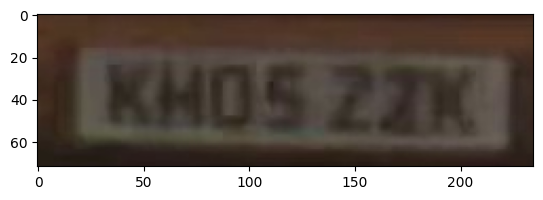

In [8]:
plt.imshow(dp.cropped_images[28])

This is an example of an image that's very dark, almost blurry, and has very low contrast between the license plate characters and the background. Feeding a raw image like this to an OCR model will not yield good results, so I will need to account for these kinds of images in my preprocessing pipeline, before performing OCR. 

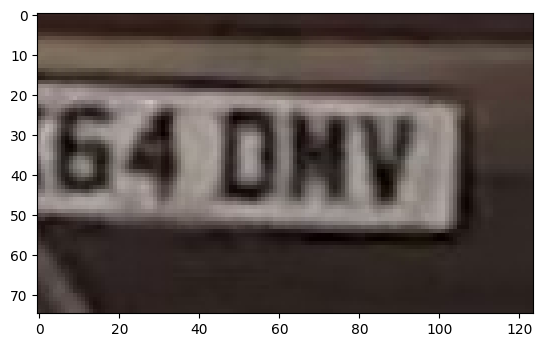

In [9]:
plt.imshow(dp.cropped_images[32])

The YOLO model does make some mistakes, however. In the above image, we can see that the bounding box failed to encapsulate the entire license plate, cutting off the first two characters from the license plate.

Further tuning of the YOLO model is required to facilitate better object detection of the license plates, especially since 1) not all the license plates in each frame are being detected, and 2) some of the bounding boxes are partially cutting off the license plates.

The object detections could potentially be improved by:
* Increasing the blob size for YOLO inputs
* Increasing the confidence threshold for the bounding boxes
* Increasing the NMS threshold for the bounding boxes

### Preparing Image for OCR

I chose the following preprocessing steps to prepare my license plate images for the OCR:

* Normalize
* Resize (want the image to be 300 PPI for optimal OCR performance)
* Remove Noise
* Skeletonize (this makes all the 'strokes' in the characters the same thickness)
* Sharpen
* Convert to Grayscale
* Pixel Thresholding to Convert to B&W

In [10]:
len(dp.preprocessed_images)

35

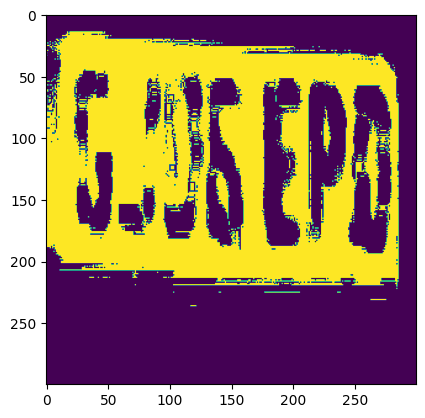

In [11]:
plt.imshow(dp.preprocessed_images[5])

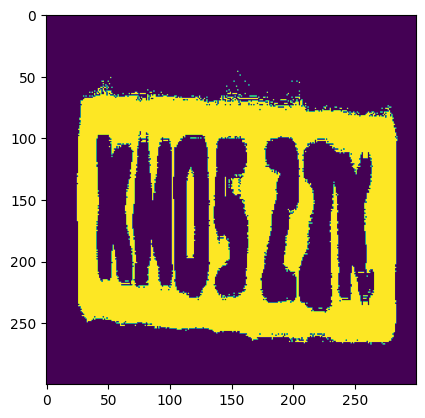

In [12]:
plt.imshow(dp.preprocessed_images[28])

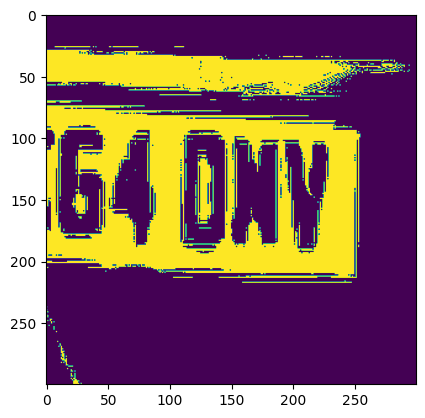

In [13]:
plt.imshow(dp.preprocessed_images[32])

## EasyOCR Results

In [14]:
dp.load()

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteText extraction completed successfully.
OCR Results saved successfully.


,Text,Confidence
0,Hlwzu,0.023024
1,FFi0gzi,0.153369
2,Im,0.401772
3,EFWIH,0.142960
4,Lgwm,0.114454
5,SJXEPH,0.039821
6,|iszq,0.075478
7,CEPD,0.172921
8,NOEPD,0.552301
9,GVSEF,0.057887


The OCR text predictions have very low confidence scores. Low confidence scores are not acceptable for our ALPR system, since we need to be able to know for sure that we are charging tolls for the correct vehicles and that we are not missing any of the vehicles passing through the toll point. 

The OCR performance could potentially be improved by fine-tuning the input image preprocessing steps, but an even more important feature to include would be the postprocessing steps and quality checks for the OCR results. 

For example, some quick quality checks for the predictions would be: 
* Most US states' license plates have between 6 - 8 characters. Any predictions that contain fewer than 6 characters or greater than 8 characters need to be discarded.
* All of the characters must be made uppercase since US license plates do not include lowercase letters.
* Many US states exclude commonly mistaken characters, such as I, O, and Q.

More detailed information on the formats of US license plates can be found here: https://privateauto.com/license-plates/how-many-characters-in-a-license-plate